# Tutorial

## Preliminaries

The following set of examples shows the user how to train a Masked Autoregressive Flow (MAF) and an example Kernel Density Estimator (KDE). We further demonstrate how to use `margarine` to estimate the Kullback Leibler divergence and Bayesian Dimensionality with the trained MAF and KDE.

We also demonstrate how to use the clustering feature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In order to demonstrate the applications of the code we need to generate some mock samples and we can visualise the posterior distributions with `anesthetic`.

In [2]:
from anesthetic import MCMCSamples

x = np.random.normal(0, 1, 1000)
y = np.random.normal(2, 0.5, 1000)

data = np.vstack([x, y]).T
weights = np.ones(len(data))

samples = MCMCSamples(data=data, weights=weights)

To visualise the posterior we use anesthetic.

,0,1
0,DiagonalAx...,OffDiagona...
1,OffDiagona...,DiagonalAx...


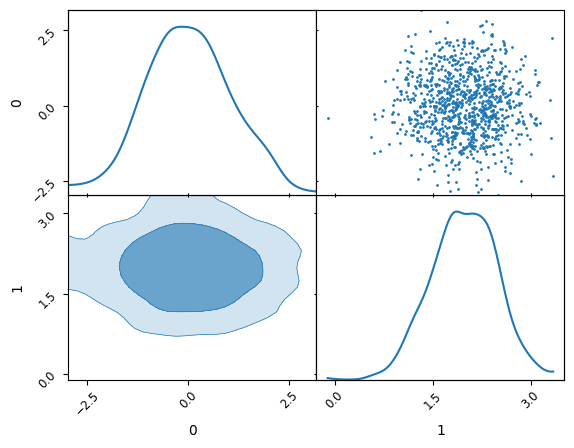

In [3]:
names = [i for i in range(2)]
samples.plot_2d(names)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `margarine`. To train the MAF we first need to initalise the class with the samples and corresponding weights. For all of the different density estimators in `margarine` the weights have to be provided by the kwarg `weights` else they are assumed to be equal unless `theta` is an instance of anesthetic.samples.

In [4]:
import os
os.chdir('../')

from margarine.maf import MAF

bij = MAF(data, weights=weights)
bij.train(10000, early_stop=True)

2023-11-29 11:45:49.647511: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c42a83e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-29 11:45:49.647528: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-29 11:45:49.662763: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-29 11:45:49.662864: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
  2%|▏         | 217/10000 [00:03<02:23, 68.08it/s] 

Early stopped. Epochs used = 217. Minimum at epoch = 17


We can then generate uniformly weighted samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

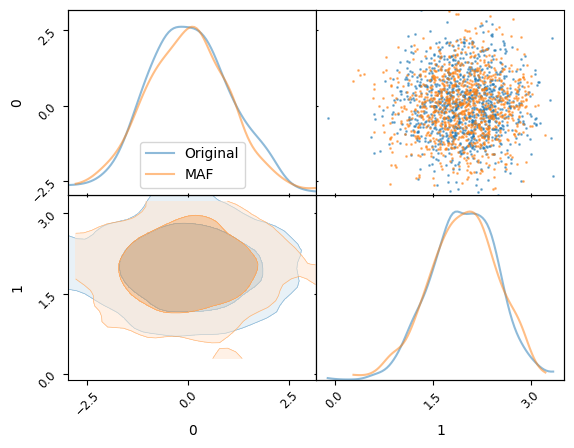

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(data), data.shape[-1])))

maf_samples = MCMCSamples(data=x, weights=np.ones(len(x)))
axes = samples.plot_2d(names, alpha=0.5, label='Original')
maf_samples.plot_2d(axes, alpha=0.5, label='MAF')
axes.iloc[0, 0].legend()


Alternatively we can generate samples with the following code which takes in an integer and returns an array of shape (int, 5). The `.sample()` function is a proxy for `__call__`.

In [6]:
x = bij.sample(5000)

2023-11-29 11:45:57.670706: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform


We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. 

The samples presented here were generated using a gaussian likelihood and fitting with nested sampling for 5 parameters. We can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for the samples for comparison. We see very similar results and note that the similarity improves with the number of epochs.

In [8]:
from margarine.marginal_stats import calculate

stats = calculate(bij).statistics()
print(stats)
print(stats['KL Divergence'])
print(stats['BMD'])

{'KL Divergence': 0.86629934037101, 'KL Lower Bound': 0.8502202671766281, 'KL Upper Bound': 0.8761215806007385, 'BMD': 1.5152902079145143, 'BMD Lower Bound': 1.5045221806401101, 'BMD Upper Bound': 1.7080930787965807}
0.86629934037101
1.5152902079145143


# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

0.8783514977954174 +(-) 0.06701173525232851 ( 0.08007262985361374 )
1.1287518165763837 +(-) 0.32010835180217834 ( 0.19720359155340383 )


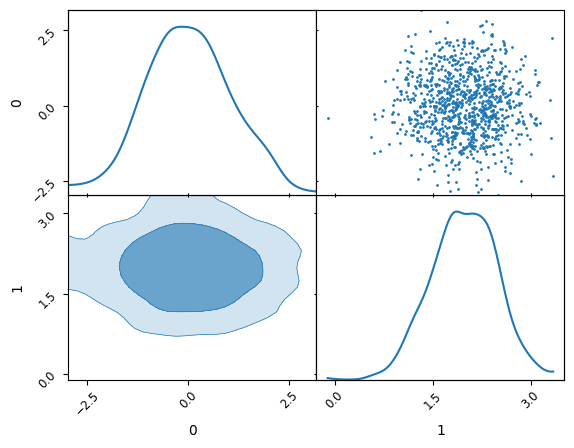

In [15]:
from margarine.kde import KDE
kde = KDE(data, weights=weights)
kde.generate_kde()
x = kde.sample(5000)

samples = MCMCSamples(data=data, weights=weights)
samples.plot_2d(names)

stats = calculate(kde).statistics()
print(stats['KL Divergence'], '+(-)', stats['KL Upper Bound'] - stats['KL Divergence'], 
      '(', stats['KL Divergence'] - stats['KL Lower Bound'], ')')
print(stats['BMD'], '+(-)', stats['BMD Upper Bound'] - stats['BMD'], 
      '(', stats['BMD'] - stats['BMD Lower Bound'], ')')

Rather than using the `kde.sample()` function to generate samples we could transform samples from the hypercube with the following code and the `__call__()` function. However, we note that this is a much slower method of generating samples as it is designed to be bijective. Transformation from the hypercube is useful if we would like to use a trained KDE or MAF as the prior in a subseqeunt nested sampling run however is not necessary if we simply want to calcualte marginal Bayesian statistics.

In [16]:
x = kde(np.random.uniform(0, 1, size=(10, data.shape[-1])))

# Clustering with margarine

The below example demonstrates how to perform clustering with `margarine` which can improve the accuracy of the emulation. The clustering class has all the same functionality as the MAF class.

,0,1
0,DiagonalAx...,OffDiagona...
1,OffDiagona...,DiagonalAx...


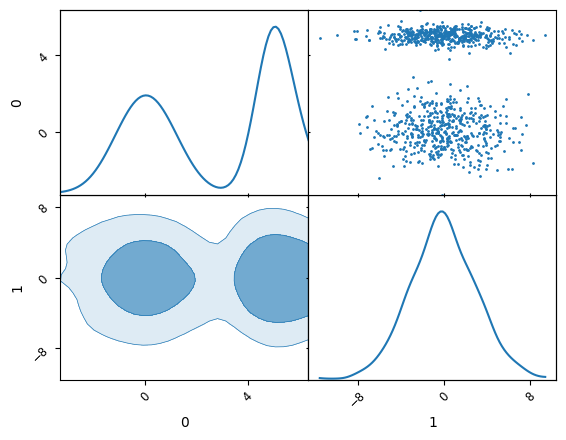

In [17]:
x = np.concatenate([np.random.normal(0, 1, 500), np.random.normal(5, 0.3, 500)])
y = np.random.normal(0, 3, 1000)

data = np.vstack([x, y]).T

samples = MCMCSamples(data=data, weights=np.ones(len(data)))
samples.plot_2d(names)

In [18]:
from margarine.clustered import clusterMAF
flow = clusterMAF(data)
flow.train(10000, early_stop=True)

 10%|▉         | 985/10000 [00:03<00:34, 260.22it/s]


Early stopped. Epochs used = 985. Minimum at epoch = 785


  5%|▍         | 499/10000 [00:02<00:55, 171.93it/s]


Early stopped. Epochs used = 499. Minimum at epoch = 299


  4%|▍         | 376/10000 [00:02<01:04, 149.18it/s]

Early stopped. Epochs used = 376. Minimum at epoch = 176



  3%|▎         | 300/10000 [00:02<01:18, 123.28it/s]

Early stopped. Epochs used = 300. Minimum at epoch = 100



 10%|▉         | 998/10000 [00:03<00:31, 282.99it/s]


Early stopped. Epochs used = 998. Minimum at epoch = 798


 12%|█▏        | 1159/10000 [00:04<00:32, 273.99it/s]

Early stopped. Epochs used = 1159. Minimum at epoch = 959


,0,1
0,DiagonalAx...,OffDiagona...
1,OffDiagona...,DiagonalAx...


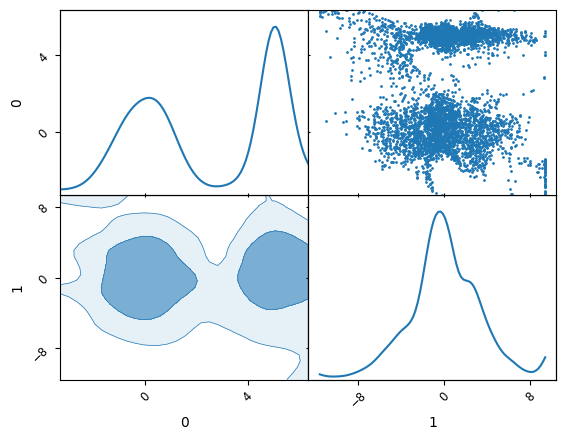

In [19]:
flow_samples = flow.sample(5000)
flow_samples = MCMCSamples(data=flow_samples, weights=np.ones(len(flow_samples)))
flow_samples.plot_2d(names)